In [1]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image 
import keras, cv2, shutil, keras_preprocessing, requests, math, glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model 
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from pathlib import Path
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)

In [2]:
train_dir = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/train/" 

In [3]:
test_dir = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/test/" 

In [4]:
target_size = (128, 128)
input_shape = (128, 128, 3)

In [5]:
batch_size = 256

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip=True,
    rotation_range = 30
)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 17651 images belonging to 120 classes.


In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4475 images belonging to 120 classes.


In [10]:
inputs = keras.Input(shape=input_shape)

base_incept_model = keras.applications.InceptionV3(input_shape=input_shape, include_top=False)
base_incept_model.trainable = False

87910968/87910968 [==============================] - 13s 0us/step


In [12]:
x = base_incept_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(120, activation='softmax')(x)
model = keras.Model(base_incept_model.input, outputs)
for layer in base_incept_model.layers: layer.trainable = False

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [15]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='convnet_from_scratch.tf', save_best_only=True, monitor='val_accuracy', mode='max')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=7, restore_best_weights = True)

In [16]:
history = model.fit(train_generator, 
            steps_per_epoch = 20,
            epochs=50,
            verbose=1,
            validation_data=test_generator, 
            callbacks=[tensorboard_callback, early_stoppage_callback, checkpoint_callback]
            )

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 7.0509 - accuracy: 0.0246INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 262s 13s/step - loss: 7.0509 - accuracy: 0.0246 - val_loss: 5.2280 - val_accuracy: 0.0807
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 4.3245 - accuracy: 0.1580INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 258s 13s/step - loss: 4.3245 - accuracy: 0.1580 - val_loss: 2.9131 - val_accuracy: 0.3321
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 2.9626 - accuracy: 0.3326INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 239s 12s/step - loss: 2.9626 - accuracy: 0.3326 - val_loss: 2.2118 - val_accuracy: 0.4585
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 2.6146 - accuracy: 0.3906INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 237s 12s/step - loss: 2.6146 - accuracy: 0.3906 - val_loss: 1.9989 - val_accuracy: 0.5053
Epoch 5/50
20/20 [==============================] - ETA: 0s - loss: 2.4294 - accuracy: 0.4323INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 243s 12s/step - loss: 2.4294 - accuracy: 0.4323 - val_loss: 1.8856 - val_accuracy: 0.5339
Epoch 6/50
20/20 [==============================] - ETA: 0s - loss: 2.3101 - accuracy: 0.4515INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 239s 12s/step - loss: 2.3101 - accuracy: 0.4515 - val_loss: 1.8144 - val_accuracy: 0.5461
Epoch 7/50
20/20 [==============================] - ETA: 0s - loss: 2.2606 - accuracy: 0.4623INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 290s 15s/step - loss: 2.2606 - accuracy: 0.4623 - val_loss: 1.7626 - val_accuracy: 0.5589
Epoch 8/50
20/20 [==============================] - ETA: 0s - loss: 2.1879 - accuracy: 0.4730INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 283s 14s/step - loss: 2.1879 - accuracy: 0.4730 - val_loss: 1.7209 - val_accuracy: 0.5672
Epoch 9/50
20/20 [==============================] - ETA: 0s - loss: 2.1932 - accuracy: 0.4703INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 257s 13s/step - loss: 2.1932 - accuracy: 0.4703 - val_loss: 1.7333 - val_accuracy: 0.5745
Epoch 10/50
20/20 [==============================] - 271s 14s/step - loss: 2.0741 - accuracy: 0.4861 - val_loss: 1.7121 - val_accuracy: 0.5712
Epoch 11/50
20/20 [==============================] - ETA: 0s - loss: 2.0588 - accuracy: 0.4920INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 290s 15s/step - loss: 2.0588 - accuracy: 0.4920 - val_loss: 1.7191 - val_accuracy: 0.5754
Epoch 12/50
20/20 [==============================] - 235s 12s/step - loss: 2.0498 - accuracy: 0.4965 - val_loss: 1.7128 - val_accuracy: 0.5741
Epoch 13/50
20/20 [==============================] - ETA: 0s - loss: 2.0500 - accuracy: 0.4979INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 265s 14s/step - loss: 2.0500 - accuracy: 0.4979 - val_loss: 1.6737 - val_accuracy: 0.5821
Epoch 14/50
20/20 [==============================] - ETA: 0s - loss: 1.9792 - accuracy: 0.5168INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 289s 15s/step - loss: 1.9792 - accuracy: 0.5168 - val_loss: 1.6932 - val_accuracy: 0.5837
Epoch 15/50
20/20 [==============================] - 256s 13s/step - loss: 1.9002 - accuracy: 0.5222 - val_loss: 1.6649 - val_accuracy: 0.5785
Epoch 16/50
20/20 [==============================] - ETA: 0s - loss: 1.9403 - accuracy: 0.5164INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 166s 9s/step - loss: 1.9403 - accuracy: 0.5164 - val_loss: 1.6324 - val_accuracy: 0.5859
Epoch 17/50
20/20 [==============================] - 171s 9s/step - loss: 1.9356 - accuracy: 0.5203 - val_loss: 1.6800 - val_accuracy: 0.5730
Epoch 18/50
20/20 [==============================] - ETA: 0s - loss: 1.9012 - accuracy: 0.5310INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 187s 10s/step - loss: 1.9012 - accuracy: 0.5310 - val_loss: 1.6616 - val_accuracy: 0.5870
Epoch 19/50
20/20 [==============================] - 138s 7s/step - loss: 1.9600 - accuracy: 0.5156 - val_loss: 1.7018 - val_accuracy: 0.5823
Epoch 20/50
20/20 [==============================] - 136s 7s/step - loss: 1.8864 - accuracy: 0.5260 - val_loss: 1.6880 - val_accuracy: 0.5743
Epoch 21/50
20/20 [==============================] - 136s 7s/step - loss: 1.8542 - accuracy: 0.5312 - val_loss: 1.7075 - val_accuracy: 0.5770
Epoch 22/50
20/20 [==============================] - 136s 7s/step - loss: 1.8284 - accuracy: 0.5357 - val_loss: 1.6732 - val_accuracy: 0.5861
Epoch 23/50
20/20 [==============================] - 136s 7s/step - loss: 1.8431 - accuracy: 0.5396 - val_loss: 1.6459 - val_accuracy: 0.5806
Epoch 24/50
20/20 [==============================] - ETA: 0s - loss: 1.7951 - accuracy: 0.5375INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets

INFO:tensorflow:Assets written to: convnet_from_scratch.tf\assets


20/20 [==============================] - 154s 8s/step - loss: 1.7951 - accuracy: 0.5375 - val_loss: 1.6200 - val_accuracy: 0.5935
Epoch 25/50
20/20 [==============================] - 203s 10s/step - loss: 1.8022 - accuracy: 0.5398 - val_loss: 1.6685 - val_accuracy: 0.5857
Epoch 26/50
20/20 [==============================] - 246s 13s/step - loss: 1.7837 - accuracy: 0.5488 - val_loss: 1.6342 - val_accuracy: 0.5873
Epoch 27/50
20/20 [==============================] - 248s 13s/step - loss: 1.7766 - accuracy: 0.5387 - val_loss: 1.7063 - val_accuracy: 0.5754
Epoch 28/50
20/20 [==============================] - 265s 14s/step - loss: 1.7598 - accuracy: 0.5545 - val_loss: 1.6922 - val_accuracy: 0.5868
Epoch 29/50
20/20 [==============================] - 287s 15s/step - loss: 1.7622 - accuracy: 0.5455 - val_loss: 1.6915 - val_accuracy: 0.5859
Epoch 30/50
20/20 [==============================] - 238s 12s/step - loss: 1.7302 - accuracy: 0.5639 - val_loss: 1.6953 - val_accuracy: 0.5853
Epoch 31/50


In [17]:
history_df = pd.DataFrame(history.history)

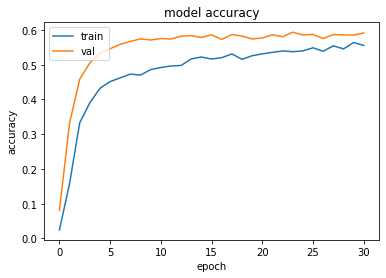

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

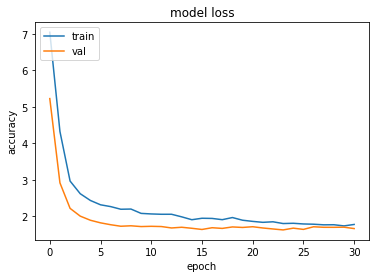

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
class_labels = []
for i in os.listdir('C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/train/'):
    class_labels.append(i)

In [21]:
predictions = []
confidence = []

In [22]:
example_images = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Test_Images/"

In [23]:
for image in os.listdir(example_images): 
    my_image = load_img(os.path.join(example_images,image), target_size=target_size)
    my_image = img_to_array(my_image)
    my_image = my_image/255
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    prediction = model.predict(my_image)
    predicted_class_index = np.argmax(prediction)
    predictions.append(class_labels[predicted_class_index])
    confidence.append(round(prediction[0][predicted_class_index] * 100, 2))

1/1 [==============================] - 0s 228ms/step


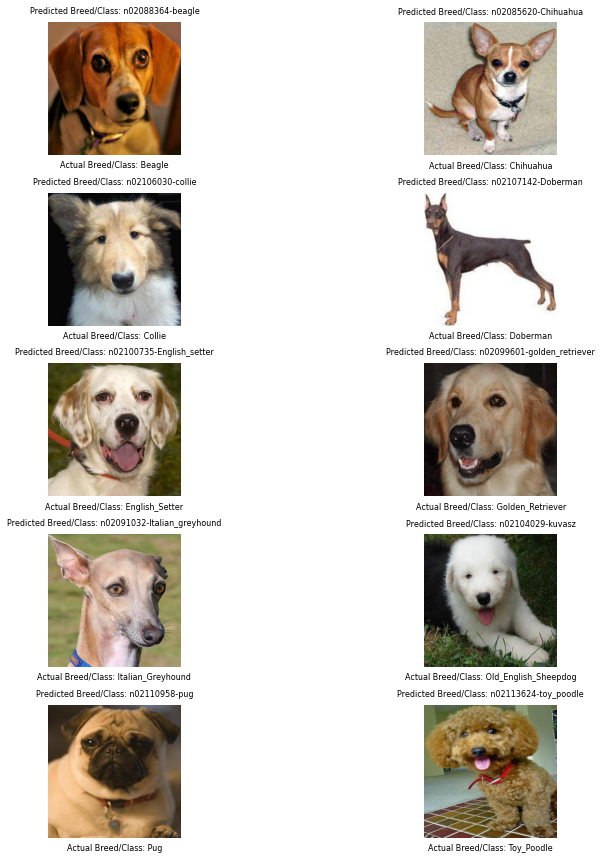

In [24]:
# Get a list of all image files in the directory
image_files = [file for file in os.listdir(example_images)]

# Set up the plot with multiple subplots
num_images = len(image_files)
num_cols = 2  # Number of columns in the plot
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the plot

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Loop through the image files and plot them
for i, file in enumerate(image_files):
    row = i // num_cols
    col = i % num_cols

    # Load the image using matplotlib's imread function
    image_path = os.path.join(example_images, file)
    image = plt.imread(image_path)

    # Plot the image on the corresponding subplot
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].text(0.5, -0.1, f'Actual Breed/Class: {os.path.splitext(file)[0]}', fontsize=8, ha='center', transform=axes[row, col].transAxes)
    axes[row, col].text(0.5, 1.06, f'Predicted Breed/Class: {predictions[i]}', fontsize=8, ha='center', transform=axes[row, col].transAxes)
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()